# Intro

We will be working with the data from [NHANES](https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017), which is the the National Health and Nutrition Examination Survey, conducted by the National Center for Health Statistics (USA). 

They follow up the survey participants for 2 years and also ask relevant demographic and dietary questions and also life-style related.

For each study (they are made every two years), we find data about:
- demographics
- diet
- examination
- laboratory
- questionnaire (mainly lifestyle related)

With this data we will try to predict a few diseases such as heart diseases or asthma.

As the data is quite noise, full of NaNs, etc... I took the surveys from several year-pairs:
- 2013-2014
- 2015-2016
- 2017-2018

This should be no problem, as it isn't a temporal serie. The survey methods can be consulted in the website.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Helpers
abspath = os.path.abspath
dirname = os.path.dirname
sep = os.sep
file_ = os.getcwd()

ml_folder = dirname(file_)
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi
from src.utils import folder_tb as fo
from src.utils import models as mo


import warnings

warnings.filterwarnings("ignore")

## Data exploration

In [2]:
# As the data variables are coded (for instance, "RIAGENDR" is Gender), we first need to load the variable descriptions. For that, we will create an object with all the info and methods to change names whenever necessary

# 1) We create the object
vardata = md.variables_data()

# 2) We load the info
vardata_path = "data" + sep + "6_variables" + sep + "0_final_variables.csv"
vardata.load_data(2, vardata_path)

In [3]:
# Now we can load the actual dataset we will be using for the ml models

# 1) Create object
dataset = md.dataset()

# 2) Load data
folders = ["1_demographics", "2_dietary", "3_examination", "4_laboratory", "5_questionnaire"]
columns_correction = {
            "WTDRD1_x" : "WTDRD1",
            "WTDR2D_x" : "WTDR2D",
            "DRABF_x" : "DRABF",
            "DRDINT_x" : "DRDINT",
            "WTSAF2YR_x" : "WTSAF2YR",
            "LBXHCT_x" : "LBXHCT"
        }
dataset.load_data(2, folders, columns_correction)

In [4]:
### DON'T EXECUTE THIS ONE

# Before doing any cleaning or transformation, let's save this dataset
path_to_save = ml_folder + sep + "data" + sep + "7_cleaned_data" + sep + "raw_data.csv"
dataset.df.to_csv(path_to_save)

In [5]:
# With this, we can do a first exploration. For that, we can access the df though the object attribute "df"

print(dataset.df.shape, "\n")
dataset.df.head(2)

(29213, 951) 



,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,SMQ690F,SMQ830,SMQ840,SMDANY,SMAQUEX,SMQ690I,SMQ857,SMQ690J,SMQ861,MCQ160H
SEQN,,,,,,,,,,,,,,,,,,,,,
83732,9,2,1,62,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,0
83733,9,2,1,53,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0


In [6]:
# This are our (target) variables of interest
print("Asthma:\n", dataset.df.MCQ010.value_counts())
print("-" * 50)
print("Congestive heart failure:\n", dataset.df.MCQ160B.value_counts())
print("-" * 50)
print("Cononary heart disease:\n", dataset.df.MCQ160C.value_counts())
print("-" * 50)
print("Angina pectoris:\n", dataset.df.MCQ160D.value_counts())
print("-" * 50)
print("Heart attack:\n", dataset.df.MCQ160E.value_counts())
print("-" * 50)
print("Stroke:\n", dataset.df.MCQ160F.value_counts())
print("-" * 50)
print("Any cardiovascular disease:\n", dataset.df.MCQ160H.value_counts())

Asthma:
 0.0    23781
1.0     4273
Name: MCQ010, dtype: int64
--------------------------------------------------
Congestive heart failure:
 0.0    16311
1.0      574
Name: MCQ160B, dtype: int64
--------------------------------------------------
Cononary heart disease:
 0.0    16169
1.0      716
Name: MCQ160C, dtype: int64
--------------------------------------------------
Angina pectoris:
 0.0    16470
1.0      415
Name: MCQ160D, dtype: int64
--------------------------------------------------
Heart attack:
 0.0    16172
1.0      713
Name: MCQ160E, dtype: int64
--------------------------------------------------
Stroke:
 0.0    16225
1.0      660
Name: MCQ160F, dtype: int64
--------------------------------------------------
Any cardiovascular disease:
 0    27371
1     1842
Name: MCQ160H, dtype: int64


In [7]:
# As we can see, it is quite wide. Let's filter by the columns we will actually be using (using our magnificent object)
# We will start by trying to predict Asthma
features = ["MCQ160H", "RIAGENDR", "RIDAGEYR", "DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR", "BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST", "LBXTR", "LBXTC", "LBXSGL", "DR1TFIBE", "DR1TVB6", "DR2TFIBE", "DR2TVB6"]

dataset.filter_columns(features, inplace = True)

In [8]:
print(dataset.df.shape)

dataset.df.info()

(29213, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29213 entries, 83732 to 102956
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   29213 non-null  int64  
 1   RIAGENDR  29213 non-null  int64  
 2   RIDAGEYR  29213 non-null  int64  
 3   DR1TCHOL  24186 non-null  float64
 4   DR1TTFAT  24186 non-null  float64
 5   DR1TSFAT  24186 non-null  float64
 6   DR1TSUGR  24186 non-null  float64
 7   DR2TCHOL  20705 non-null  float64
 8   DR2TTFAT  20705 non-null  float64
 9   DR2TSFAT  20705 non-null  float64
 10  DR2TSUGR  20705 non-null  float64
 11  BPXDI1    20466 non-null  float64
 12  BPXSY1    20466 non-null  float64
 13  BMXWT     27574 non-null  float64
 14  DXDTOPF   13272 non-null  float64
 15  BMXWAIST  24419 non-null  float64
 16  LBXTR     8624 non-null   float64
 17  LBXTC     21457 non-null  float64
 18  LBXSGL    18552 non-null  float64
 19  DR1TFIBE  24186 non-null  float64
 20  DR1TVB6   2

In [9]:
# Since que can't pass NaN values to the model, we need to do some transformation or drop some values here
# Let's get some more info about the data before doing anything

dataset.df.describe()

,MCQ160H,RIAGENDR,RIDAGEYR,DR1TCHOL,DR1TTFAT,DR1TSFAT,DR1TSUGR,DR2TCHOL,DR2TTFAT,DR2TSFAT,...,BMXWT,DXDTOPF,BMXWAIST,LBXTR,LBXTC,LBXSGL,DR1TFIBE,DR1TVB6,DR2TFIBE,DR2TVB6
count,29213.000000,29213.000000,29213.000000,24186.000000,24186.000000,24186.000000,24186.000000,20705.000000,20705.000000,20705.000000,...,27574.000000,13272.000000,24419.000000,8624.000000,21457.000000,18552.000000,24186.000000,24186.000000,20705.000000,20705.000000
mean,0.063054,1.509054,32.342895,267.568469,76.938708,25.458654,106.280634,257.322338,70.498384,23.432803,...,63.251462,32.062967,88.259249,108.876971,179.887123,101.747844,15.355044,1.892124,15.277377,1.884547
std,0.243064,0.499927,24.828824,234.045424,45.577694,16.273312,70.781600,221.094807,41.618728,15.234315,...,32.560457,8.598014,22.739996,103.197779,40.943273,37.996146,10.181685,1.622596,10.129809,1.443274
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.100000,11.700000,40.000000,10.000000,69.000000,19.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,10.000000,111.000000,45.192500,14.261500,59.422500,107.000000,41.550000,13.046000,...,38.800000,25.600000,72.000000,58.000000,150.000000,86.000000,8.500000,1.020000,8.400000,1.036000
50%,0.000000,2.000000,28.000000,198.000000,67.980000,22.017000,91.870000,194.000000,62.310000,20.227000,...,66.100000,31.800000,89.200000,87.000000,175.000000,93.000000,13.200000,1.566000,13.200000,1.588000
75%,0.000000,2.000000,54.000000,358.000000,98.147500,32.812500,135.652500,342.000000,90.540000,30.237000,...,84.300000,38.800000,103.800000,131.000000,204.000000,103.000000,19.800000,2.303000,19.800000,2.331000
max,1.000000,2.000000,80.000000,3515.000000,567.960000,223.759000,1115.500000,2666.000000,530.220000,259.210000,...,242.600000,56.100000,177.900000,4233.000000,813.000000,626.000000,136.300000,48.321000,134.800000,24.988000


In [10]:
# MCQ160H (first one in the matrix) is out target value (any cardiovascular disease in this case)
# Let's check the variable

dataset.df.MCQ160H.value_counts()

0    27371
1     1842
Name: MCQ160H, dtype: int64

In [11]:
# 0 --> he/she hasn't had any cardiovascular disease
# 1 --> he/she has had any cardiovascular disease

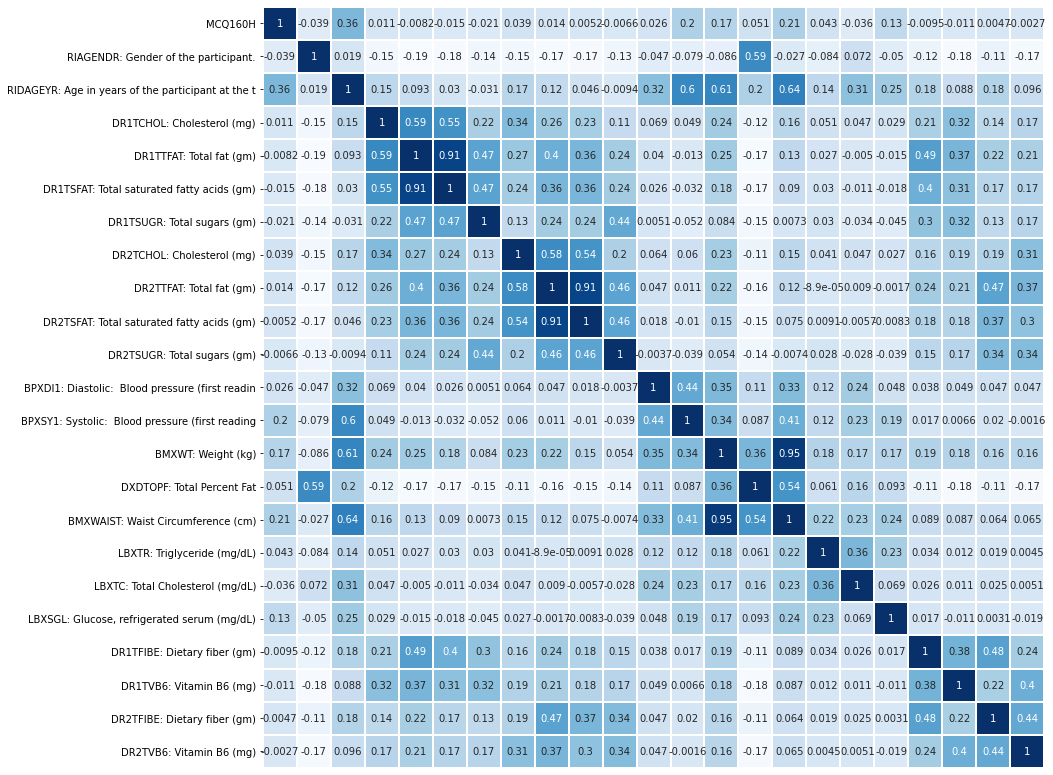

In [13]:
# Let's check the correlations

# 1) We pull the variables names from our vardata object
features_names = vardata.vars_descr_detector(list(dataset.df.columns), 40, True)

# 2) We create the plotter object
plotter = vi.eda_plotter(dataset.df, features_names)
# 3) Now we use the correlation_matrix method
fig = plotter.correlation_matrix(figsize = (14, 14))

# To save all the plots as images later
eda_plots_path = fo.path_to_folder(2, "reports" + sep + "eda_plots")
# Saving plot
plt.savefig(eda_plots_path + "Correlation_matrix.pdf", format = "pdf")

In [14]:
# Well, it looks like our chosen independent variables are not quite linearly related with having any cardiovascular disease.
# Let's continue the analysis though: Outliers

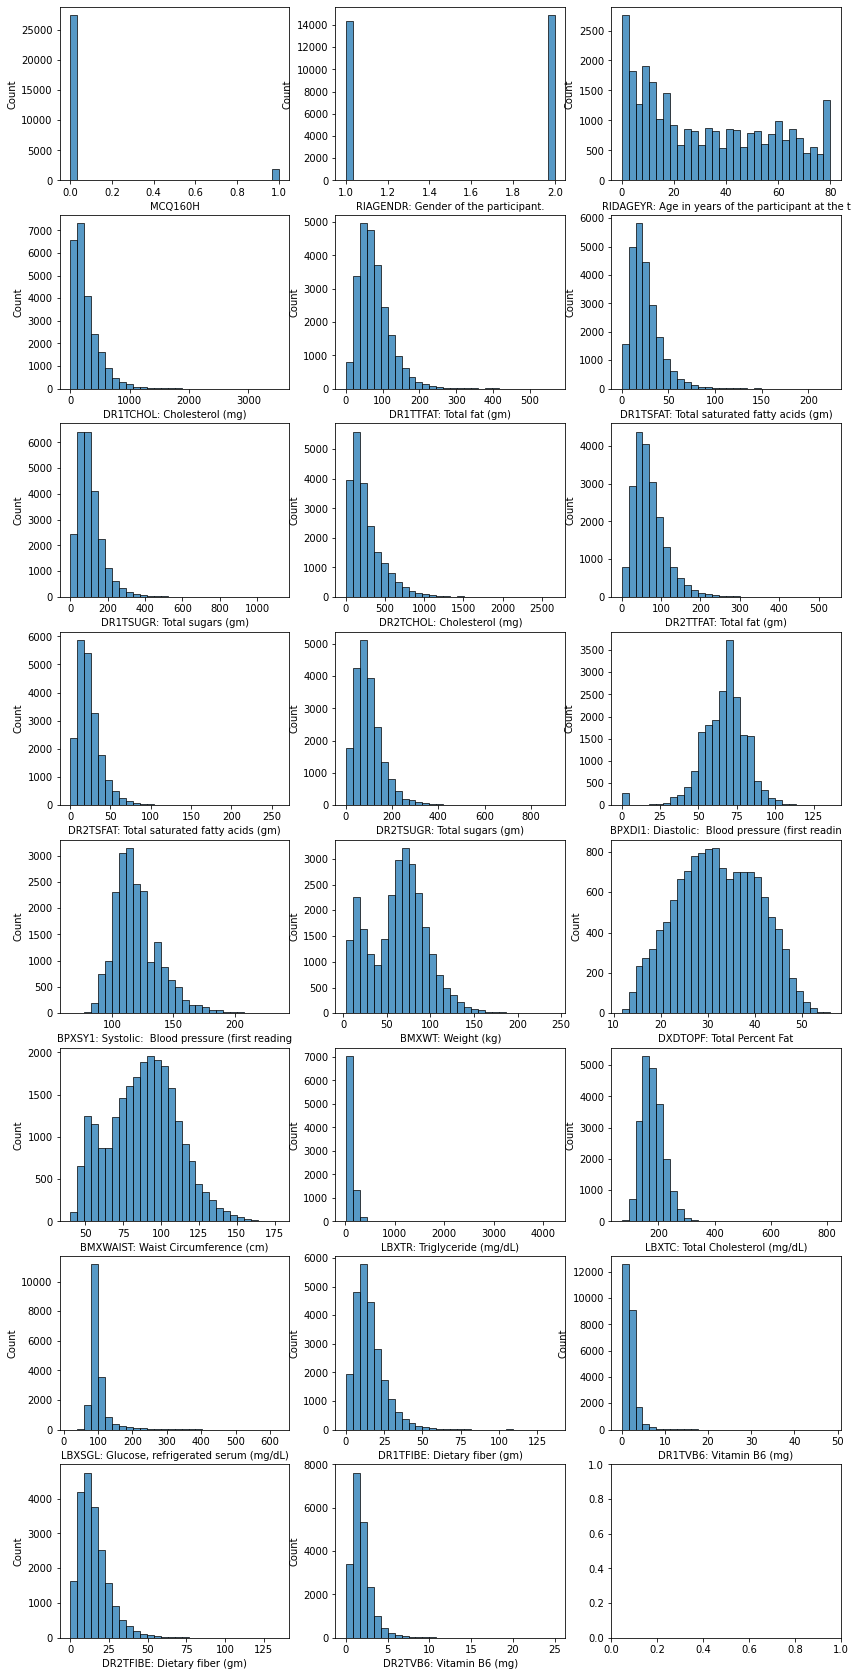

In [15]:
fig2 = plotter.multi_axes_plotter(3, "stripplot", (14, 30))
plt.savefig(eda_plots_path + "Distribution_plots.pdf", format = "pdf")

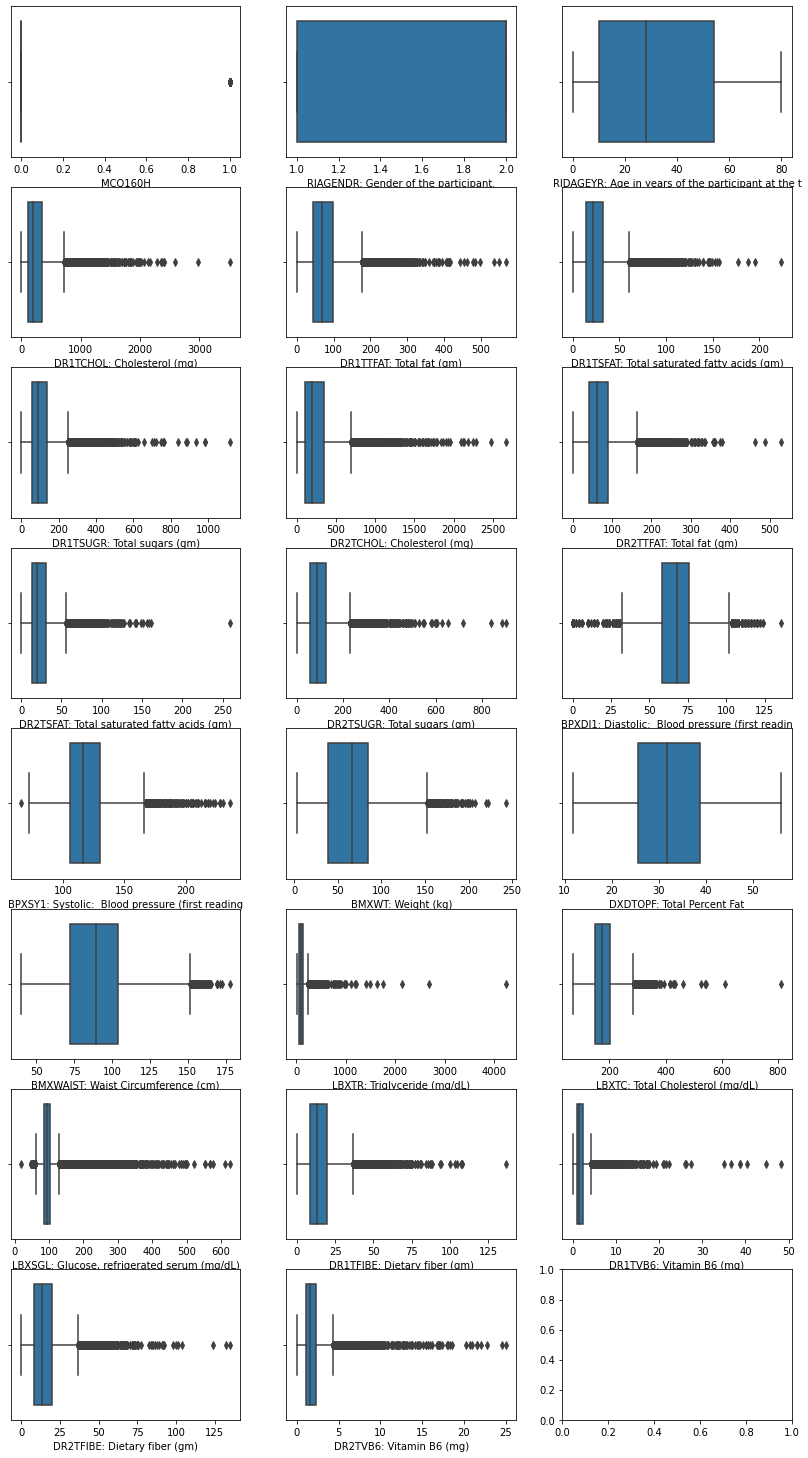

In [16]:
fig3 = plotter.multi_axes_plotter(3, "box", (14, 26))
plt.savefig(eda_plots_path + "Box_plots.pdf", format = "pdf")

In [17]:
# Well, we have quite a few outliers
# To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers
# So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time

DR1TTFAT_outliers = dataset.df[dataset.df.DR1TTFAT > 200]

print("shape:", DR1TTFAT_outliers.shape)
print("\nTarget values:")
print(DR1TTFAT_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(DR1TTFAT_outliers.isna().sum())

shape: (458, 23)

Target values:
0    432
1     26
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H       0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL      0
DR1TTFAT      0
DR1TSFAT      0
DR1TSUGR      0
DR2TCHOL     66
DR2TTFAT     66
DR2TSFAT     66
DR2TSUGR     66
BPXDI1       38
BPXSY1       38
BMXWT         4
DXDTOPF     149
BMXWAIST     10
LBXTR       269
LBXTC        27
LBXSGL       44
DR1TFIBE      0
DR1TVB6       0
DR2TFIBE     66
DR2TVB6      66
dtype: int64


In [18]:
# As we can see, there are quite a few positive cases (MCQ010 == 1) within the fat outliers. This means, by removing the outliers we would also remove valuable information for our model to detect when someone is likely to have asthma.

# We have to keep in mind that our data is already quite imbalanced, so the more positive target values we keep, the better.

# Let's do a simple calculation to see if it's worth to remove the outliers here mentioned.
# The ratio of positive/data in out full dataset is = 4278 / (4278 + 23819) ~ 0.15225

# If the ratio in the outliers is below that number, it would mean that we are removing more negative than positive ones, so it could be worth. However, for this batch this is not the case:
# 85 / (374 + 85) ~ 0.18518

In [19]:
# Let's check blood pressure

BPXDI1_outliers = dataset.df[(dataset.df.BPXDI1 < 26) | (dataset.df.BPXDI1 > 105)]

print("shape:", BPXDI1_outliers.shape)
print("\nTarget values:")
print(BPXDI1_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(BPXDI1_outliers.isna().sum())

shape: (391, 23)

Target values:
0    360
1     31
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H       0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL     61
DR1TTFAT     61
DR1TSFAT     61
DR1TSUGR     61
DR2TCHOL    104
DR2TTFAT    104
DR2TSFAT    104
DR2TSUGR    104
BPXDI1        0
BPXSY1        0
BMXWT         6
DXDTOPF     145
BMXWAIST     18
LBXTR       293
LBXTC        42
LBXSGL      184
DR1TFIBE     61
DR1TVB6      61
DR2TFIBE    104
DR2TVB6     104
dtype: int64


In [20]:
# Here we have a similar case as before: we'd be removing more positive than negative labels:
# 66 / (327 + 66) ~ 0.1679

In [21]:
# Well, we have quite a few outliers
# To keep in mind: since some of the independent variables are highly correlated, it's likely for them to have the same observations as outliers. For instance, DR1TTFAT and DR1STFAT are likely to have same participants as outliers
# So, by removing the outliers from one of the correlated columns, we are cleaning the other one at the same time

LBXSGL_outliers = dataset.df[dataset.df.LBXSGL > 150]

print("shape:", LBXSGL_outliers.shape)
print("\nTarget values:")
print(LBXSGL_outliers.iloc[:, 0].value_counts())
print("\nNaNs:")
print(LBXSGL_outliers.isna().sum())

shape: (1097, 23)

Target values:
0    851
1    246
Name: MCQ160H, dtype: int64

NaNs:
MCQ160H       0
RIAGENDR      0
RIDAGEYR      0
DR1TCHOL    114
DR1TTFAT    114
DR1TSFAT    114
DR1TSUGR    114
DR2TCHOL    240
DR2TTFAT    240
DR2TSFAT    240
DR2TSUGR    240
BPXDI1       98
BPXSY1       98
BMXWT        27
DXDTOPF     717
BMXWAIST     98
LBXTR       592
LBXTC         0
LBXSGL        0
DR1TFIBE    114
DR1TVB6     114
DR2TFIBE    240
DR2TVB6     240
dtype: int64


In [22]:
# Same as previous examples 176 / (928 + 176) ~ 0.1594

In [23]:
# We will see how the models work with the data as it is
# Now, let's remove the NaNs to avoid issues with the model

to_drop = ["LBXTR", "DXDTOPF"]
dataset.drop_columns(to_drop)
dataset.drop_nans()
dataset.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13446 entries, 83732 to 102956
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   13446 non-null  int64  
 1   RIAGENDR  13446 non-null  int64  
 2   RIDAGEYR  13446 non-null  int64  
 3   DR1TCHOL  13446 non-null  float64
 4   DR1TTFAT  13446 non-null  float64
 5   DR1TSFAT  13446 non-null  float64
 6   DR1TSUGR  13446 non-null  float64
 7   DR2TCHOL  13446 non-null  float64
 8   DR2TTFAT  13446 non-null  float64
 9   DR2TSFAT  13446 non-null  float64
 10  DR2TSUGR  13446 non-null  float64
 11  BPXDI1    13446 non-null  float64
 12  BPXSY1    13446 non-null  float64
 13  BMXWT     13446 non-null  float64
 14  BMXWAIST  13446 non-null  float64
 15  LBXTC     13446 non-null  float64
 16  LBXSGL    13446 non-null  float64
 17  DR1TFIBE  13446 non-null  float64
 18  DR1TVB6   13446 non-null  float64
 19  DR2TFIBE  13446 non-null  float64
 20  DR2TVB6   13446 non-nul

In [24]:
# Here we have several variables that refer to the exact same thing. For instance:
# DR1TCHOL --> Total Cholesterol the first interview day
# DR2TCHOL --> Total Cholesterol the second interview day

# As we want the users to be able to enter their data, it's going to be easier to ask them for just one measure per risk factor. Thus, we'll combine the similar rows by calculating the mean

# [[pairs we want to combine], new column name]
comb1 = [["DR1TCHOL", "DR2TCHOL"], "MEANCHOL"]      # Total Cholesterol (mg)
comb2 = [["DR1TTFAT", "DR2TTFAT"], "MEANTFAT"]      # Total Fat (g)
comb3 = [["DR1TSFAT", "DR2TSFAT"], "MEANSFAT"]      # Total Saturated Fatty Acid (g)
comb4 = [["DR1TSUGR", "DR2TSUGR"], "MEANSUGR"]      # Total Sugar (g)
comb5 = [["DR1TFIBE", "DR2TFIBE"], "MEANFIBE"]      # Total Fiber (g)
comb6 = [["DR1TVB6", "DR2TVB6"], "MEANTVB6"]        # Total Vitamin B6 (mg)

# list of all combinations
combs = [comb1, comb2, comb3, comb4, comb5, comb6]

# process them
dataset.pairs_mean(combs, drop_old = True)

In [25]:
print(dataset.df.shape)
dataset.df.info()

(13446, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13446 entries, 83732 to 102956
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MCQ160H   13446 non-null  int64  
 1   RIAGENDR  13446 non-null  int64  
 2   RIDAGEYR  13446 non-null  int64  
 3   BPXDI1    13446 non-null  float64
 4   BPXSY1    13446 non-null  float64
 5   BMXWT     13446 non-null  float64
 6   BMXWAIST  13446 non-null  float64
 7   LBXTC     13446 non-null  float64
 8   LBXSGL    13446 non-null  float64
 9   MEANCHOL  13446 non-null  float64
 10  MEANTFAT  13446 non-null  float64
 11  MEANSFAT  13446 non-null  float64
 12  MEANSUGR  13446 non-null  float64
 13  MEANFIBE  13446 non-null  float64
 14  MEANTVB6  13446 non-null  float64
dtypes: float64(12), int64(3)
memory usage: 1.6 MB


In [26]:
# One final thing to do before feeding the data into the models is transforming the gender variable (RIAGENDR) into a dummy one:
dataset.df.RIAGENDR.value_counts()

2    6928
1    6518
Name: RIAGENDR, dtype: int64

In [27]:
# We will do this making use of one of the object's method
mapper = {1 : "Male", 2 : "Female"}
dataset.dummies_transform("RIAGENDR", mapper)
dataset.df.head(2)

,MCQ160H,RIDAGEYR,BPXDI1,BPXSY1,BMXWT,BMXWAIST,LBXTC,LBXSGL,MEANCHOL,MEANTFAT,MEANSFAT,MEANSUGR,MEANFIBE,MEANTVB6,Female,Male
SEQN,,,,,,,,,,,,,,,,
83732,0,62,70.0,128.0,94.8,101.1,173.0,94.0,386.5,100.415,31.9250,80.355,19.75,2.7810,0,1
83733,0,53,88.0,146.0,90.4,107.9,265.0,94.0,590.0,116.230,29.3455,107.680,9.75,2.4455,0,1


In [28]:
### DON'T EXECUTE THIS ONE

# We will take this dataset as it is and save it as our cleaned data, because it's the one we'll be using for ML and neural networks

path_to_save = ml_folder + sep + "data" + sep + "7_cleaned_data" + sep + "cleaned_data.csv"
dataset.df.to_csv(path_to_save)

## ML Models and Predictions

### Ensembler

As there are many possibilities when it comes to classification models, we will test them all and have a look at the main metrics to see which one performs better. From there, we will decide which one we want to keep for further tuning.

In [29]:
### Prepare data for the ML models
# We won't scale or balance the data for this first round
dataset.model_data(split = .2, cv = 3, epochs = 1)

### Choose models for test against each other
# Same seed of all of them
seed = 42

# Logistic Regression
log1 = LogisticRegression(n_jobs = -1, random_state = seed)
log2 = LogisticRegression(n_jobs = -1, max_iter = 300, random_state = seed)

# Random Forest
rf1 = RandomForestClassifier(n_jobs = -1, random_state = seed)
rf2 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_depth = 10)
rf3 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_depth = 20) 
rf4 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_features = "sqrt") 
rf5 = RandomForestClassifier(n_jobs = -1, random_state = seed, max_features = "log2") 

# KNeighbors
knn1 = KNeighborsClassifier(n_jobs = -1)
knn2 = KNeighborsClassifier(n_jobs = -1, weights = "distance")

models = [log1, log2, rf1, rf2, rf3, rf4, rf5, knn1, knn2]

### Models comparison
# Ensemble models
ensembler = mo.model_ensembler(models)
# Load data
ensembler.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)
# Train them
ensembler.models_tester()
# Let's see the performance
ensembler.metrics

,Test_score,Train_score,Test_score_drop,Accuracy,Precision,Recall,F1_score,Confusion_matrix
"LogisticRegression(max_iter=300, n_jobs=-1, random_state=42)",0.92119,0.916512,0.005104,0.92119,0.58,0.131818,0.214815,"[[2449, 21], [191, 29]]"
"RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)",0.919331,0.934827,-0.016577,0.919331,0.8,0.018182,0.035556,"[[2469, 1], [216, 4]]"
"RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)",0.919331,0.97183,-0.054021,0.919331,0.571429,0.054545,0.099585,"[[2461, 9], [208, 12]]"
"LogisticRegression(n_jobs=-1, random_state=42)",0.918587,0.916512,0.002265,0.918587,0.510204,0.113636,0.185874,"[[2446, 24], [195, 25]]"
"RandomForestClassifier(n_jobs=-1, random_state=42)",0.918216,0.972109,-0.055439,0.918216,0.5,0.036364,0.067797,"[[2462, 8], [212, 8]]"
"RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42)",0.918216,0.972109,-0.055439,0.918216,0.5,0.036364,0.067797,"[[2462, 8], [212, 8]]"
"RandomForestClassifier(max_features='log2', n_jobs=-1, random_state=42)",0.918216,0.972109,-0.055439,0.918216,0.5,0.036364,0.067797,"[[2462, 8], [212, 8]]"
KNeighborsClassifier(n_jobs=-1),0.914498,0.918929,-0.004822,0.914498,0.421875,0.122727,0.190141,"[[2433, 37], [193, 27]]"
"KNeighborsClassifier(n_jobs=-1, weights='distance')",0.914498,0.969319,-0.056556,0.914498,0.421875,0.122727,0.190141,"[[2433, 37], [193, 27]]"


Models are sorted by "Test_score" on descending value.

We can see that LogisticRegression is the model that's actually performaing the best, improving its performance when working with the test data

In [30]:
### DON'T EXECUTE THIS ONE

# We will save this first models comparison
path_to_save = ml_folder + sep + "models" + sep + "model_comparison_noscale_nobalance.csv"
ensembler.metrics.to_csv(path_to_save)

# Now we will save all the models (in the same folder)
path_to_save = path_to_save = ml_folder + sep + "models" + sep + "model_comparison_noscale_nobalance"
ensembler.models_saver(path_to_save)

'Succesfully saved'

In [31]:
# Now, let's try the same but scaling and balancing the data

# Data
dataset.model_data(split = .2, cv = 3, epochs = 1, scaler = True, balance = .8)

# Seed
seed = 42

# We will use the same models, so no need to redefine them
### Models comparison
# Ensemble models
ensembler2 = mo.model_ensembler(models)
# Load data
ensembler2.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)
# Train them
ensembler2.models_tester()
# Let's see the performance
ensembler2.metrics

,Test_score,Train_score,Test_score_drop,Accuracy,Precision,Recall,F1_score,Confusion_matrix
"RandomForestClassifier(n_jobs=-1, random_state=42)",0.870632,0.975739,-0.107721,0.870632,0.308383,0.468182,0.371841,"[[2239, 231], [117, 103]]"
"RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42)",0.870632,0.975739,-0.107721,0.870632,0.308383,0.468182,0.371841,"[[2239, 231], [117, 103]]"
"RandomForestClassifier(max_features='log2', n_jobs=-1, random_state=42)",0.870632,0.975739,-0.107721,0.870632,0.308383,0.468182,0.371841,"[[2239, 231], [117, 103]]"
"RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)",0.85948,0.974329,-0.117875,0.85948,0.28877,0.490909,0.363636,"[[2204, 266], [112, 108]]"
"RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)",0.817472,0.904254,-0.095971,0.817472,0.255856,0.645455,0.366452,"[[2057, 413], [78, 142]]"
"LogisticRegression(n_jobs=-1, random_state=42)",0.795167,0.786956,0.010435,0.795167,0.254815,0.781818,0.384358,"[[1967, 503], [48, 172]]"
"LogisticRegression(max_iter=300, n_jobs=-1, random_state=42)",0.795167,0.786956,0.010435,0.795167,0.254815,0.781818,0.384358,"[[1967, 503], [48, 172]]"
KNeighborsClassifier(n_jobs=-1),0.762454,0.890375,-0.143671,0.762454,0.206171,0.668182,0.315113,"[[1904, 566], [73, 147]]"
"KNeighborsClassifier(n_jobs=-1, weights='distance')",0.762454,0.957741,-0.203904,0.762454,0.205345,0.663636,0.313641,"[[1905, 565], [74, 146]]"


Well, it seems like all the models are performing worse in terms of test score. However, we can see how all of them have a better recall, meaning that they are better at the detecting the positives, which is our main goal.

Surprise: RandomForest is now the one performing better, although we can see that all RandomForest models are overfitting.

We will better stick to LogisticRegression model for further tests

In [32]:
### DON'T EXECUTE THIS ONE

# We will save this first models comparison
path_to_save = ml_folder + sep + "models" + sep + "model_comparison_scale_balance.csv"
ensembler2.metrics.to_csv(path_to_save)

# Now we will save all the models (in the same folder)
path_to_save = path_to_save = ml_folder + sep + "models" + sep + "model_comparison_scale_balance"
ensembler2.models_saver(path_to_save)

'Succesfully saved'

Now that we have chosen LogisticRegression, let's get deeper into the model details

In [33]:
# Let's prepare the data and choose a model

# 1) Prepare data for ml models
dataset.model_data(split = .2, cv = 10, epochs = 1, scaler = True, balance = 1)

# 2) Choose model
model = LogisticRegression(n_jobs = -1, max_iter = 500, warm_start = True)

# 3) We create a ml_model object and load the data
my_model = mo.ml_model(model)

# Load data
my_model.load_data(dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test, features_names, dataset.kfold)

# 4) We train the model
my_model.ml_trainer(verb = True)


-- Model 1 --
-------------------------
>train score: 0.7936696005416385
>test score: 0.8005076142131979
-------------------------
Set structure:
Train structure: {0: 0.5, 1: 0.5}
Validation structure: {0: 0.5, 1: 0.5}
###########################################################################

-- Model 2 --
-------------------------
>train score: 0.7945159106296547
>test score: 0.7944162436548223
-------------------------
Set structure:
Train structure: {0: 0.5, 1: 0.5}
Validation structure: {0: 0.5, 1: 0.5}
###########################################################################

-- Model 3 --
-------------------------
>train score: 0.7947980139923267
>test score: 0.7944162436548223
-------------------------
Set structure:
Train structure: {0: 0.5, 1: 0.5}
Validation structure: {0: 0.5, 1: 0.5}
###########################################################################

-- Model 4 --
-------------------------
>train score: 0.7945159106296547
>test score: 0.7979695431472081
------

We can see that balancing the data forced the train and validation sets to be apro 50/50. This will come in handy later, when we try to predict the positives, as we are now helping the model overcome the bias in the data.

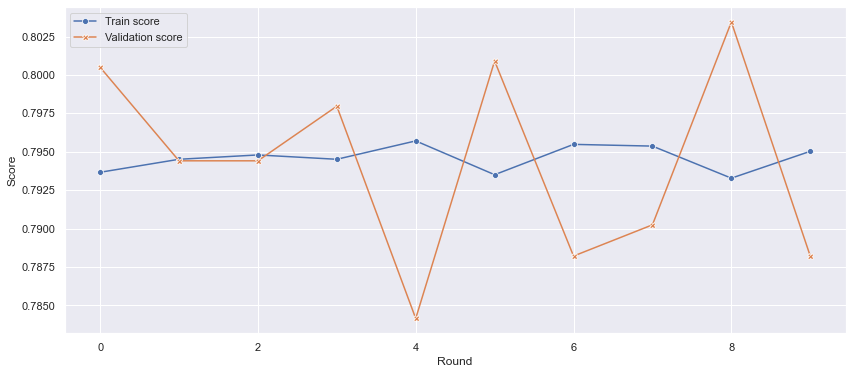

In [38]:
# To plot the results, we will use a new object
plotter2 = vi.ml_model_plotter(my_model)

# 1) Plot validation vs training scores progression
fig4 = plotter2.train_val_plot()

# To save all the plots as images later
ml_plots_path = fo.path_to_folder(2, "reports" + sep + "ml_plots")
# Saving plot
plt.savefig(ml_plots_path + "Cross_validation.pdf", format = "pdf")

It looks like the validation score varies a bit too much compared to the training score.

In [35]:
# Let's see how the model does with the test data
my_model.ml_tester(verb = True)

Train structure: {0: 50.0, 1: 50.0}
Test structure: {0: 91.82156133828995, 1: 8.178438661710038}
###########################################################################
>Train score: 0.7943536102366203
>Test score: 0.7613382899628253
###########################################################################
Confusion matrix
[[1869  601]
 [  41  179]]
###########################################################################
Precision metrics
Accuracy: 0.7613382899628253
Precision: 0.22948717948717948
Recall: 0.8136363636363636
F1 score: 0.358


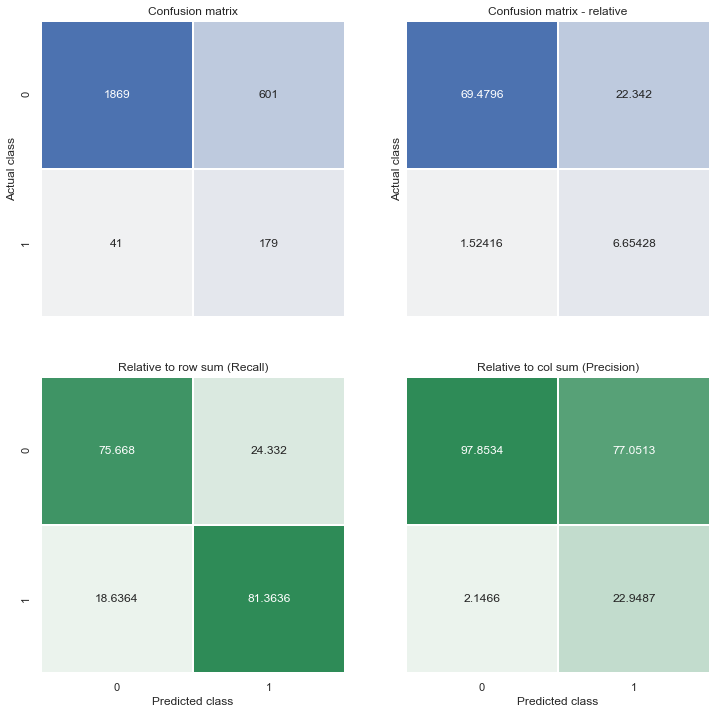

In [39]:
fig5 = plotter2.test_metrics()
plt.savefig(ml_plots_path + "Test_data.pdf", format = "pdf")

We can see that our model is predicting most of the positive values correctly (80.9%), although the price for that is a huge amount of false positive (77.15%).

We have already tried several ml models, but none of them is quite there yet. Let's see how a neural network performs here.

In [37]:
### DON'T EXECUTE THIS ONE

# Now we will save this model as the best one so far
path_to_save = path_to_save = ml_folder + sep + "models" + sep + "best_ml_model"
my_model.model_saver(path_to_save)

'Succesfully saved'

## Neural net

## Time distribution and thoughts on the project